# Continuous Control

---

## 1. Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ddpg_agent import Agent

## 2. Instantiate the Environment and 20 Agents

In [3]:
# initialize the environment
env = UnityEnvironment(file_name='./Reacher_20.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
# initialize agents
random_seed = 2
agent = Agent(state_size, action_size, random_seed, num_agents)

## 3. Train the Agent with DDPG

In [6]:
def ddpg(n_episodes=1000, max_t=300, print_every=100, 
         num_agents=20, eps_greedy=False):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): episodes interval to print training scores
        num_agents (int): the number of agents
        eps_greedy (bool): whether use Epsilon-Greedy policy to choose Action in Actor
                            Note: Critic won't use Epsilon-Greedy policy.
    """
    scores_deque = deque(maxlen=print_every)
    scores = []
    if eps_greedy:
        eps_start=1.0
        eps_end=0.01 
        eps_decay=0.995
        eps = eps_start
    else:
        eps = 0.
    
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # get the current state (for each agent)
        states = env_info.vector_observations
        # initialize the score (for each agent)
        scores_ = np.zeros(num_agents)
        for t in range(max_t):
            # select an action (for each agent)
            actions = agent.act(states, eps)
            #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            #actions = np.clip(actions, -1, 1)
            # send action to the environment
            env_info = env.step(actions)[brain_name]
            # get the next_state, reward, done (for each agent)
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            # store experience and train the agent
            agent.step(states, actions, rewards, next_states, dones)
            # roll over state to next time step
            states = next_states
            # update the score
            scores_ += rewards
            # exit loop if episode finished
            if np.any(dones):
                break 
        # save most recent score
        scores_deque.append(scores_.mean())
        scores.append(scores_.mean())
        # decrease epsilon after each epsilon
        if eps_greedy:
            eps = max(eps_end, eps_decay*eps)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

Episode 10	Average Score: 0.02
Episode 20	Average Score: 0.01
Episode 30	Average Score: 0.03
Episode 40	Average Score: 0.04
Episode 50	Average Score: 0.06
Episode 60	Average Score: 0.09
Episode 70	Average Score: 0.08
Episode 80	Average Score: 0.11
Episode 90	Average Score: 0.05
Episode 100	Average Score: 0.07


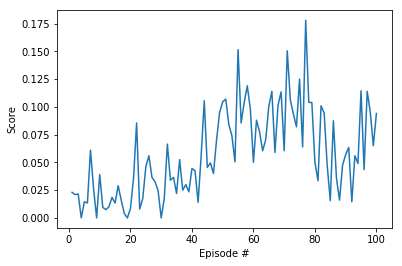

In [7]:
scores = ddpg(n_episodes=100, max_t=30, print_every=10)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#env.close()